In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Input,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import grangercausalitytests


# 1 - Data Preprocessing

In [2]:
def processar_dados_ano(caminho_arquivo, escolas_comuns):
    df = pd.read_csv(caminho_arquivo, encoding='latin1', sep=None, engine='python', on_bad_lines='skip')
    df = df[df['CO_ENTIDADE'].isin(escolas_comuns)]
    colunas_para_remover = [col for col in df.columns if (col.startswith('DS_') or col.startswith('NU_') or col.startswith('DT_') or col.startswith('CO_') or col.startswith('NO_'))]
    df_limpo = df.drop(columns=colunas_para_remover).drop(columns=['SG_UF'])
    colunas_com_nan = df_limpo.columns[df_limpo.isnull().any()].tolist()
    df_limpo = df_limpo.dropna(subset=colunas_com_nan)
    return df_limpo, colunas_com_nan

diretorio = 'dataset/'
primeiro_ano = 2008
caminho_arquivo = f'{diretorio}microdados_ed_basica_{primeiro_ano}_alagoas.csv'
df_primeiro_ano = pd.read_csv(caminho_arquivo, encoding='latin1', sep=None, engine='python', on_bad_lines='skip')
escolas_comuns = set(df_primeiro_ano['CO_ENTIDADE'].unique())

for ano in range(primeiro_ano + 1, 2022):
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df = pd.read_csv(caminho_arquivo, encoding='latin1', sep=None, engine='python', on_bad_lines='skip')
    escolas_comuns = escolas_comuns.intersection(set(df['CO_ENTIDADE'].unique()))

dfs = [] 
matriculas_por_ano = []
docentes_por_ano = []
turmas_por_ano = []
brancas_por_ano = []
pardas_por_ano = []
diurno_por_ano = []
noturno_por_ano = []
masculino_por_ano = []
feminino_por_ano = []
mat_fund_por_ano = []
docentes_esp_por_ano = []
anos = range(primeiro_ano, 2022)

# Processar dados de cada ano
for ano in anos:
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df_limpo, colunas_com_nan = processar_dados_ano(caminho_arquivo, escolas_comuns)
    dfs.append(df_limpo)
    
    # Somar o número de matrículas para o ano
    total_matriculas = df_limpo['QT_MAT_BAS'].sum()
    total_mat_fund = df_limpo['QT_MAT_FUND'].sum()
    doc_por_ano = df_limpo['QT_DOC_BAS'].sum()
    tur_por_ano = df_limpo['QT_TUR_BAS'].sum()
    bra_por_ano = df_limpo['QT_MAT_BAS_BRANCA'].sum()
    pra_por_ano = df_limpo['QT_MAT_BAS_PARDA'].sum()
    d_por_ano = df_limpo['QT_MAT_BAS_D'].sum()
    n_por_ano = df_limpo['QT_MAT_BAS_N'].sum()
    fem_por_ano = df_limpo['QT_MAT_BAS_FEM'].sum()
    mas_por_ano = df_limpo['QT_MAT_BAS_MASC'].sum()
    doc_esp_por_ano = df_limpo['QT_DOC_ESP'].sum()

    
    matriculas_por_ano.append(total_matriculas)
    docentes_por_ano.append(doc_por_ano)
    turmas_por_ano.append(tur_por_ano)
    brancas_por_ano.append(bra_por_ano)
    pardas_por_ano.append(pra_por_ano)
    diurno_por_ano.append(d_por_ano)
    noturno_por_ano.append(n_por_ano) 
    docentes_esp_por_ano.append(doc_esp_por_ano)
    feminino_por_ano.append(fem_por_ano)
    masculino_por_ano.append(mas_por_ano)
    mat_fund_por_ano.append(total_mat_fund)

    
    # print(f"Resumo dos dados de {ano}:")
    # print(colunas_com_nan)
    # print("--------------------------------------------------------------------\n")
    # print(df_limpo.describe())

df_consolidado = pd.concat(dfs, ignore_index=True)

In [3]:

# # Calcular a matriz de correlação
# correlacao = df_consolidado.corr()

# # Definir o limiar de correlação
# limiar_correlacao = 0.7

# # Selecionar as variáveis que têm correlação forte com QT_MAT_BAS
# correlacoes_fortes_qt_mat_bas = correlacao['QT_MAT_BAS'][np.abs(correlacao['QT_MAT_BAS']) > limiar_correlacao]

# # Obter a lista de variáveis fortemente correlacionadas
# variaveis_fortes_lista = correlacoes_fortes_qt_mat_bas.index.drop('QT_MAT_BAS').tolist()

# # Adicionar novamente QT_MAT_BAS para garantir que ele está no DataFrame final
# variaveis_fortes_lista.append('QT_MAT_BAS')

# # Filtrar o DataFrame para incluir apenas as variáveis fortes
# corr = df_consolidado[variaveis_fortes_lista].corr()
# csv = corr.to_csv('teste.csv')

In [4]:
dados_ano = {'NU_ANO_CENSO': list(anos), 'QT_MAT_BAS': matriculas_por_ano,'QT_TUR_BAS': turmas_por_ano, 'QT_DOC_BAS': docentes_por_ano, 'QT_MAT_BAS_BRANCA': brancas_por_ano, 'QT_MAT_BAS_PARDA': pardas_por_ano, 'QT_MAT_BAS_D': diurno_por_ano, 'QT_MAT_BAS_N': noturno_por_ano, 'QT_MAT_BAS_FEM': feminino_por_ano, 'QT_MAT_BAS_MASC': masculino_por_ano, 'QT_MAT_FUND': mat_fund_por_ano, 'QT_DOC_ESP': docentes_esp_por_ano}
df_consolidado = pd.DataFrame(dados_ano)

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def criar_janelas_deslizantes(sequencia, janela_tamanho):
    X, y = [], []
    for i in range(len(sequencia) - janela_tamanho):
        X.append(sequencia[i:(i + janela_tamanho)])
        y.append(sequencia[i + janela_tamanho, 0])  # Prevê a próxima observação (o primeiro atributo da sequência)
    return np.array(X), np.array(y)


In [6]:
dados = df_consolidado[['QT_MAT_BAS','QT_TUR_BAS','QT_DOC_BAS', 'QT_MAT_BAS_BRANCA', 'QT_MAT_BAS_PARDA', 'QT_MAT_BAS_D', 'QT_MAT_BAS_N', 'QT_MAT_BAS_FEM', 'QT_MAT_BAS_MASC', 'QT_MAT_FUND', 'QT_DOC_ESP']].values


scaler = MinMaxScaler(feature_range=(0, 1))
dados_escalados = scaler.fit_transform(dados)
print("Dados escalonados:")
print(dados_escalados[:5])  
X, y = criar_janelas_deslizantes(dados_escalados, 3)
# X, y = criar_janelas_completas(dados_escalados)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Dados escalonados:
[[0.99603966 0.87169043 0.09965157 0.         0.         0.09401915
  1.         0.99387108 0.99855007 1.         0.        ]
 [1.         1.         0.46829268 0.40075191 0.34219843 0.09913
  0.98762141 1.         1.         0.947861   0.09385075]
 [0.78962695 0.84215886 0.48850174 0.45321674 0.41336982 0.08581567
  0.70605146 0.78712425 0.79252414 0.8197261  0.32880005]
 [0.76972667 0.94348269 0.94634146 0.72825582 0.64345904 0.06743697
  0.74036691 0.7762024  0.76223019 0.72752375 0.45928835]
 [0.60632221 0.79658859 0.20557491 0.8089807  0.71658486 0.04000685
  0.56412837 0.613502   0.59801069 0.60293081 0.54692538]]
Shape of X: (11, 3, 11)
Shape of y: (11,)


In [7]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 2 - Training the Model

In [8]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten,RepeatVector,Bidirectional

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))  # Kernel size alterado
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, validation_data=(X_test, y_test))


In [9]:
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
# from tensorflow.keras.models import Sequential
# import numpy as np

# def create_model(lstm_units1=200, lstm_units2=100, kernel_size=1):
#     model = Sequential()
#     model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) 
#     model.add(MaxPooling1D(pool_size=1))
#     model.add(Conv1D(filters=128, kernel_size=kernel_size, activation='relu'))
#     model.add(MaxPooling1D(pool_size=1))
#     model.add(LSTM(lstm_units1, return_sequences=True ))
#     model.add(LSTM(lstm_units2, return_sequences=False))
#     # model.add(Dropout(dropout_rate))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')
#     return model

# # Parâmetros a testar manualmente
# params = {
#     "lstm_units1": [100, 200, 300],
#     "lstm_units2": [50, 100],
#     "dropout_rate": [0.2, 0.3],
#     "kernel_size": [1, 2]
# }

# results = []

# for lstm1 in params["lstm_units1"]:
#     for lstm2 in params["lstm_units2"]:
#         for ker in params["kernel_size"]:
#             print(f"Training with lstm_units1={lstm1}, lstm_units2={lstm2}")
#             model = create_model(lstm_units1=lstm1, lstm_units2=lstm2,kernel_size=ker)
#             history = model.fit(X_train, y_train, epochs=200, batch_size=256, verbose=0, validation_data=(X_test, y_test))
            
#             # Avaliar o desempenho
#             y_pred = model.predict(X_test)
#             mae = np.mean(np.abs(y_test - y_pred))
#             print(f"MAE: {mae}")
            
#             # Armazenar os resultados
#             results.append({
#                 "lstm_units1": lstm1,
#                 "lstm_units2": lstm2,
#                 "kernel_size": ker,
#                 # "dropout_rate": dr,
#                 "MAE": mae
#             })

# # Ordenar os resultados pelo menor MAE
# sorted_results = sorted(results, key=lambda x: x["MAE"])

# # Mostrar as melhores combinações
# for res in sorted_results[:10]:
#     print(f"LSTM1: {res['lstm_units1']}, LSTM2: {res['lstm_units2']} -> MAE: {res['MAE']}")


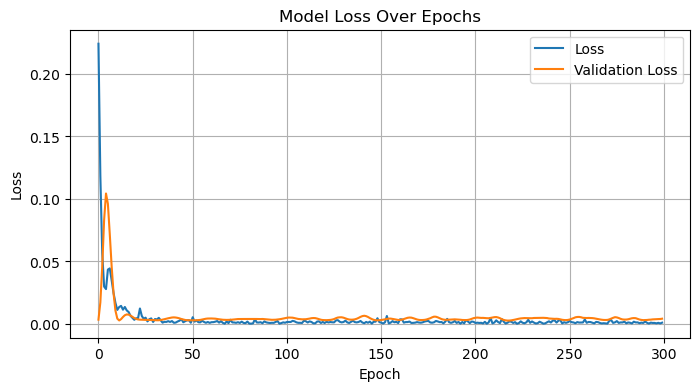

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

train_predict_rescaled = scaler.inverse_transform(
    np.concatenate([train_predict, np.zeros((train_predict.shape[0], dados_escalados.shape[1] - 1))], axis=-1)
)[:, 0]

test_predict_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((y_pred.shape[0], dados_escalados.shape[1] - 1))], axis=-1)
)[:, 0]
# Como estamos usando todas as observações anteriores, não precisamos mais de janela_tamanho
train_index = list(range(len(train_predict_rescaled)))
test_index = list(range(len(train_predict_rescaled), len(train_predict_rescaled) + len(test_predict_rescaled)))


Tamanho total dos dados: 11
Quantidade de dados no treinamento: 8
Quantidade de dados no teste: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


In [12]:
from sklearn import metrics
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], dados_escalados.shape[1] - 1))], axis=-1))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], X.shape[2] - 1))], axis=-1))[:, 0]

print('MAE:', metrics.mean_absolute_error(y_test_rescaled, test_predict_rescaled))
print('MSE:', metrics.mean_squared_error(y_test_rescaled, test_predict_rescaled))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_rescaled, test_predict_rescaled)))
print('R²:', metrics.r2_score(y_test_rescaled, test_predict_rescaled))


MAE: 11485.701329809925
MSE: 209852351.68638793
RMSE: 14486.281499625358
R²: -1.103552967096781


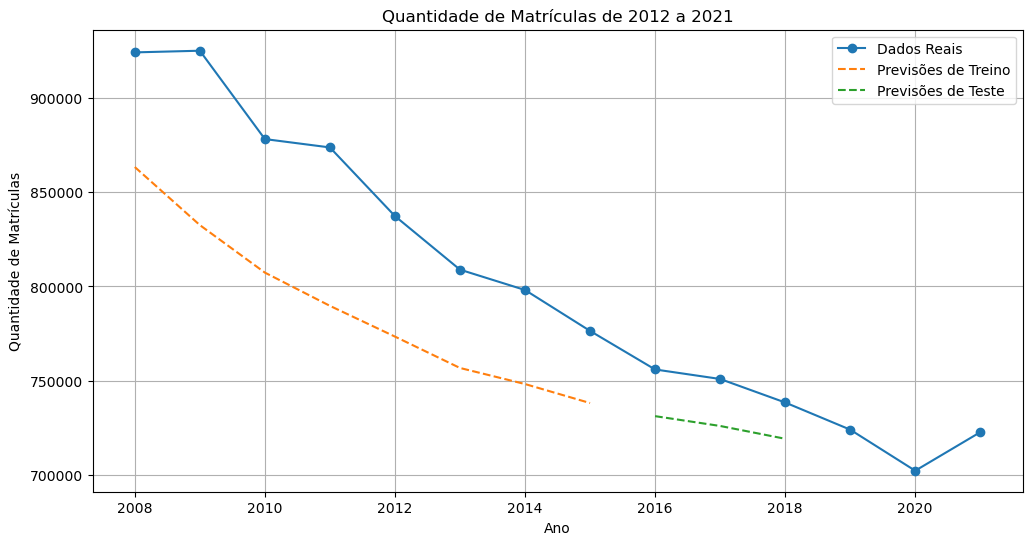

In [13]:
# Plotagem dos resultados
plt.figure(figsize=(12, 6))
plt.plot(df_consolidado['NU_ANO_CENSO'], df_consolidado['QT_MAT_BAS'], label='Dados Reais', marker='o')
plt.plot(df_consolidado['NU_ANO_CENSO'][train_index], train_predict_rescaled, label='Previsões de Treino', linestyle='--')
plt.plot(df_consolidado['NU_ANO_CENSO'][test_index], test_predict_rescaled, label='Previsões de Teste', linestyle='--')
plt.title('Quantidade de Matrículas de 2012 a 2021')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Matrículas')
plt.legend()
plt.grid(True)
plt.show()

In [14]:

# Dados de exemplo: Substitua com seus dados reais
data = {
    'QT_MAT_BAS': matriculas_por_ano,  # Sua série alvo
    'QT_DOC_BAS': doc_por_ano,         # Outra variável
    'QT_TUR_BAS': turmas_por_ano,
    'QT_MAT_BAS_BRANCA': brancas_por_ano,
    'QT_MAT_BAS_PARDA': pardas_por_ano,
    'QT_MAT_BAS_FEM': feminino_por_ano,
    'QT_MAT_BAS_MASC': masculino_por_ano,
    'QT_DOC_ESP': doc_esp_por_ano,
    'QT_MAT_FUND': mat_fund_por_ano

}

# Converter para DataFrame
df = pd.DataFrame(data)

# Verificar e imprimir colunas constantes
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"Coluna constante encontrada: {column} - Valor: {df[column].iloc[0]}")

# Remover colunas constantes
df = df.loc[:, df.nunique() > 1]

# Verificar os dados após remoção
print("Dados após remoção de colunas constantes:")
print(df.head())

# Definir o número máximo de lags para testar
maxlag = 2
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """ Cria uma matriz de causalidade de Granger mostrando os valores-p para cada par de variáveis."""
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# Executar a função com o seu DataFrame
causation_matrix = grangers_causation_matrix(df, variables=df.columns, verbose=True)

# Exibir a matriz de causalidade de Granger
print(causation_matrix)


Coluna constante encontrada: QT_DOC_BAS - Valor: 34370
Coluna constante encontrada: QT_DOC_ESP - Valor: 21850
Dados após remoção de colunas constantes:
   QT_MAT_BAS  QT_TUR_BAS  QT_MAT_BAS_BRANCA  QT_MAT_BAS_PARDA  \
0      924380       30932              74719            281966   
1      925264       31436              84206            327489   
2      878306       30816              85448            336957   
3      873864       31214              91959            367566   
4      837390       30637              93870            377294   

   QT_MAT_BAS_FEM  QT_MAT_BAS_MASC  QT_MAT_FUND  
0          466388           457992       620147  
1          467122           458142       608459  
2          441628           436678       579735  
3          440320           433544       559066  
4          420835           416555       531136  
Y = QT_MAT_BAS, X = QT_MAT_BAS, P Values = [1.0, 1.0]
Y = QT_TUR_BAS, X = QT_MAT_BAS, P Values = [0.0007, 0.0174]
Y = QT_MAT_BAS_BRANCA, X = QT_MAT_BAS

c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou

Y = QT_MAT_BAS, X = QT_MAT_BAS_PARDA, P Values = [0.0005, 0.0922]
Y = QT_TUR_BAS, X = QT_MAT_BAS_PARDA, P Values = [0.0018, 0.0208]
Y = QT_MAT_BAS_BRANCA, X = QT_MAT_BAS_PARDA, P Values = [0.0, 0.0]
Y = QT_MAT_BAS_PARDA, X = QT_MAT_BAS_PARDA, P Values = [1.0, 1.0]
Y = QT_MAT_BAS_FEM, X = QT_MAT_BAS_PARDA, P Values = [0.0002, 0.017]
Y = QT_MAT_BAS_MASC, X = QT_MAT_BAS_PARDA, P Values = [0.002, 0.564]
Y = QT_MAT_FUND, X = QT_MAT_BAS_PARDA, P Values = [0.0, 0.0]
Y = QT_MAT_BAS, X = QT_MAT_BAS_FEM, P Values = [0.6688, 0.9024]
Y = QT_TUR_BAS, X = QT_MAT_BAS_FEM, P Values = [0.0007, 0.0214]
Y = QT_MAT_BAS_BRANCA, X = QT_MAT_BAS_FEM, P Values = [0.0001, 0.0]
Y = QT_MAT_BAS_PARDA, X = QT_MAT_BAS_FEM, P Values = [0.8196, 0.0]
Y = QT_MAT_BAS_FEM, X = QT_MAT_BAS_FEM, P Values = [1.0, 1.0]
Y = QT_MAT_BAS_MASC, X = QT_MAT_BAS_FEM, P Values = [0.677, 0.4987]
Y = QT_MAT_FUND, X = QT_MAT_BAS_FEM, P Values = [0.1136, 0.0009]
Y = QT_MAT_BAS, X = QT_MAT_BAS_MASC, P Values = [0.6688, 0.9024]
Y = QT_TUR_BA

c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\artur\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou